# Image Classification with ResNet50 on CIFAR-10

By Sebastian Bangemann

## Project Objective

In this project, I train a neural network on the CIFAR-10 dataset to classify images into 10 different categories. The main goal is to apply a pre-trained model (ResNet50) and fine-tune it using transfer learning to adapt it to the new dataset.

## Workflow

1. Import of required libraries
2. Loading and subsetting the CIFAR-10 dataset
3. Preprocessing and normalizing the image data
4. Initializing the **ResNet50 model** with `imagenet` weights
5. Building a custom classification head
6. Training steps:
   - Training of head layers first (10 epochs)
   - Fine-tuning the entire model (additional 10 epochs)
7. Model evaluation on the test set
8. Final conclusion and recommendations

> 💡 Note: Training may take some time depending on the hardware (e.g., Google Colab), so please be patient!


Let’s start by importing the libraries and preparing the dataset!

## 1. Import of required libraries

In [ ]:
# Standard imports
import numpy as np
import pandas as pd
import polars as pl
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Conv2D, GlobalAveragePooling2D, Dense, Flatten, Dropout
)
from tensorflow.keras.layers import LeakyReLU

# Optimizers
from tensorflow.keras.optimizers import Adam, SGD  # Adam and SGD with momentum

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## 2. Loading and subsetting the CIFAR-10 dataset




> I use ResNet50 as the base model for transfer learning. Since it was pre-trained on ImageNet, it has already learned to detect general visual features such as edges, textures, and shapes. I reuse these features to classify CIFAR-10 images more efficiently.

In [ ]:
# Load CIFAR-10 dataset
(train_images,train_labels),(test_images,test_labels) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Limiting to 10,000 samples

In [ ]:
# Limiting to 10,000 samples
n = 10000
train_images = train_images[:n]
train_labels = train_labels[:n]

In [ ]:
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(10000, 32, 32, 3) (10000, 1)
(10000, 32, 32, 3) (10000, 1)


> I limited the training set to 10,000 samples for faster experimentation. Here I show the class distribution within this subset to ensure it remains balanced.

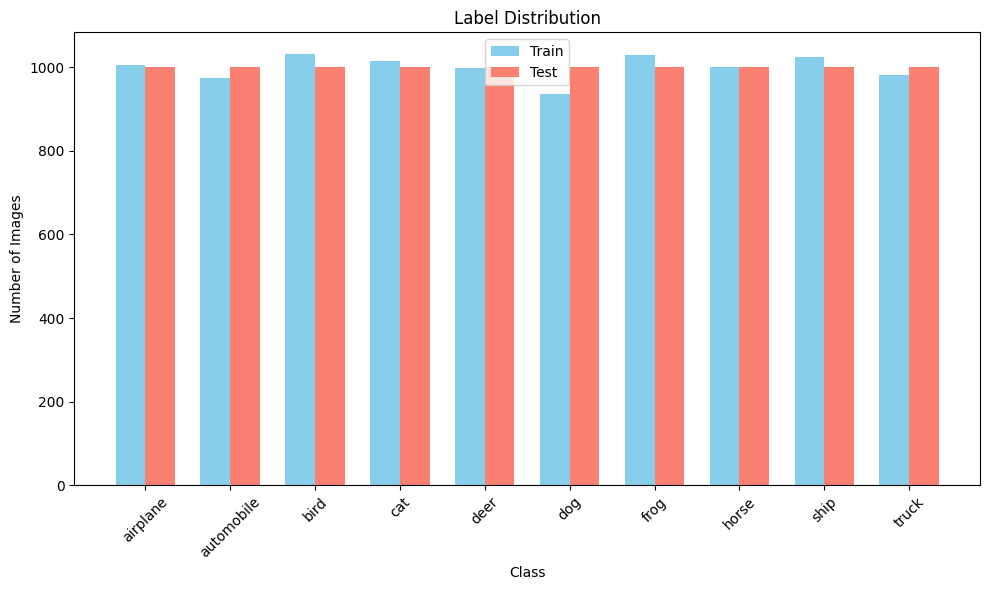

In [ ]:
# Flatten copies of label arrays (without overwriting originals)
train_labels_flat = train_labels.flatten()
test_labels_flat = test_labels.flatten()

# Class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Count occurrences in both sets
train_counts = np.bincount(train_labels_flat, minlength=10)
test_counts = np.bincount(test_labels_flat, minlength=10)

# Plot side-by-side bar chart
x = np.arange(len(class_names))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, train_counts, width, label='Train', color='skyblue')
plt.bar(x + width/2, test_counts, width, label='Test', color='salmon')
plt.xticks(x, class_names, rotation=45)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Label Distribution')
plt.legend()
plt.tight_layout()
plt.show()

## 3. Preprocessing and normalizing the image data

In [ ]:
# Normalizing values
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [ ]:
# One-Hot-Encoding
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

## 4. Initializing the ResNet50 model with `imagenet` weights

In [ ]:
# Base model ResNet50 without classification head
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

In [ ]:
# Freezing layers (transfer learning)
for layer in base_model.layers:
    layer.trainable = False

## 5. Building a custom classification head

> I add a custom classification head with multiple dense layers and dropout regularization. This allows the model to adapt high-level features from ResNet50 to the specific classes in the CIFAR-10 dataset.

In [ ]:
# Load base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model.trainable = False  # Freeze base model

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(10, activation='softmax')(x)

# Combine base model and head
model = Model(inputs=base_model.input, outputs=predictions)

## 6. Training steps

> I first train only the custom head while keeping the base model frozen. After that, I fine-tune the entire model to improve performance. I also use callbacks like early stopping and learning rate scheduling to optimize training.

### Training of head layers first (10 epochs)

In [ ]:
# Compile the model (only the head is trainable at this stage)
model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [ ]:
# Train only the head of the model (ResNet50 base remains frozen)
history_head = model.fit(
    train_images, train_labels,
    epochs=10,
    validation_data=(test_images, test_labels)
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 97s 279ms/step - accuracy: 0.1041 - loss: 2.4640 - val_accuracy: 0.1011 - val_loss: 2.3027
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 137s 265ms/step - accuracy: 0.1109 - loss: 2.3077 - val_accuracy: 0.1001 - val_loss: 2.3029
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 140s 260ms/step - accuracy: 0.1216 - loss: 2.2981 - val_accuracy: 0.1194 - val_loss: 2.2570
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 84s 265ms/step - accuracy: 0.1273 - loss: 2.2661 - val_accuracy: 0.1601 - val_loss: 2.2005
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 265ms/step - accuracy: 0.1378 - loss: 2.2410 - val_accuracy: 0.1874 - val_loss: 2.1368
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 139s 257ms/step - accuracy: 0.1646 - loss: 2.1719 - val_accuracy: 0.1927 - val_loss: 2.1017
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 84s 264ms/step - accuracy: 0.1794 - loss: 2.1317 - val_accuracy: 0.2111 - val_loss: 2.0846
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 145s 273ms/step - accuracy: 0.1952 - lo

### Fine-tuning the entire model (additional 10 epochs)

In [ ]:
# Unfreeze the base model so its layers can be trained
base_model.trainable = True

In [ ]:
# Select optimizer: 'adam'or 'sgd'
chosen_optimizer = 'adam'  # Change this string to try different optimizers

lr_adam = 1e-4
lr_sgd = 1e-4
momentum_sgd = 0.9

if chosen_optimizer == 'adam':
    optimizer = Adam(learning_rate=lr_adam)
elif chosen_optimizer == 'sgd':
    optimizer = SGD(learning_rate=lr_sgd, momentum=momentum_sgd)
else:
    raise ValueError("Unsupported optimizer! Choose from: 'adam', 'sgd', 'adamw'")

# Compile model with selected optimizer
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Stop training when the validation loss doesn't improve for 3 consecutive epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an augmented image generator for training data

rotation_range = 0        # Angle for rotation
width_shift_range = 0     # Horizontal shifting (between 0 and 1)
height_shift_range = 0    # Vertical shifting   (between 0 and 1)
horizontal_flip = False   # Horizontal mirroring

datagen = ImageDataGenerator(
    rotation_range=rotation_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    horizontal_flip=horizontal_flip
)

# Fit the generator to training data
datagen.fit(train_images)

In [ ]:
# Fine-tuning with data augmentation and callbacks
# Train the full model (base + head) with specified batch size and augmented data
batch_size = 32

history_finetune = model.fit(
    datagen.flow(train_images, train_labels, batch_size=batch_size),
    epochs=10,
    validation_data=(test_images, test_labels),
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 743s 2s/step - accuracy: 0.2002 - loss: 2.3457 - val_accuracy: 0.0999 - val_loss: 6.3487 - learning_rate: 1.0000e-04
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 698s 2s/step - accuracy: 0.4180 - loss: 1.5889 - val_accuracy: 0.1220 - val_loss: 2.9904 - learning_rate: 1.0000e-04
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 687s 2s/step - accuracy: 0.5723 - loss: 1.2277 - val_accuracy: 0.4849 - val_loss: 1.4554 - learning_rate: 1.0000e-04
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 690s 2s/step - accuracy: 0.6582 - loss: 1.0079 - val_accuracy: 0.6411 - val_loss: 1.0709 - learning_rate: 1.0000e-04
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 684s 2s/step - accuracy: 0.7313 - loss: 0.8134 - val_accuracy: 0.6724 - val_loss: 1.0173 - learning_rate: 1.0000e-04
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 687s 2s/step - accuracy: 0.7824 - loss: 0.6616 - val_accuracy: 0.6813 - val_loss: 1.0189 - learning_rate: 1.0000e-04
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accur

Reset model, when changing parameters.

> **Note:** Only run this code, when you are changing the parameters

In [ ]:
'''
# Clear current Keras/TensorFlow session
from tensorflow.keras import backend as K
K.clear_session()

# Load base model again (without top/classification head)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model.trainable = False  # Freeze base model again

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(512)(x)             # if LeakyReLu doesn't improve, then add *activation='relu'* to Dense layer
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.3)(x)

x = Dense(128)(x)             # if LeakyReLu doesn't improve, then add *activation='relu'* to Dense layer
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.25)(x)

x = Dense(128)(x)             # if LeakyReLu doesn't improve, then add *activation='relu'* to Dense layer
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.2)(x)

predictions = Dense(10, activation='softmax')(x)

# Create new model instance
model = Model(inputs=base_model.input, outputs=predictions)

# Compile again with your preferred learning rate
model.compile(optimizer=Adam(learning_rate=1e-3),  # Change LR as needed
              loss='categorical_crossentropy',
              metrics=['accuracy'])
#'''

"\n# Clear current Keras/TensorFlow session\nfrom tensorflow.keras import backend as K\nK.clear_session()\n\n# Load base model again (without top/classification head)\nbase_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))\nbase_model.trainable = False  # Freeze base model again\n\n# Add custom classification head\nx = base_model.output\nx = GlobalAveragePooling2D()(x)\n\nx = Dense(512)(x)             # if LeakyReLu doesn't improve, then add *activation='relu'* to Dense layer\nx = LeakyReLU(alpha=0.1)(x)\nx = Dropout(0.3)(x)\n\nx = Dense(256)(x)             # if LeakyReLu doesn't improve, then add *activation='relu'* to Dense layer\nx = LeakyReLU(alpha=0.1)(x)\nx = Dropout(0.25)(x)\n\nx = Dense(128)(x)             # if LeakyReLu doesn't improve, then add *activation='relu'* to Dense layer\nx = LeakyReLU(alpha=0.1)(x)\nx = Dropout(0.2)(x)\n\npredictions = Dense(10, activation='softmax')(x)\n\n# Create new model instance\nmodel = Model(inputs=base_model.inp

Now I am going to save the best model.

In [ ]:
model.save('best_model_resnet50_cifar10.h5')

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('best_model_resnet50_cifar10.h5')
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)

print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

313/313 - 43s - 139ms/step - accuracy: 0.7167 - loss: 0.9723
Test accuracy: 0.7167
Test loss: 0.9723


## 7. Model evaluation on the test set

### Model Evaluation

In [ ]:
loss, accuracy = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

313/313 - 39s - 125ms/step - accuracy: 0.7167 - loss: 0.9723
Test Loss: 0.9723
Test Accuracy: 0.7167


> I plot training and validation accuracy to visualize model performance and to detect overfitting or underfitting during training.

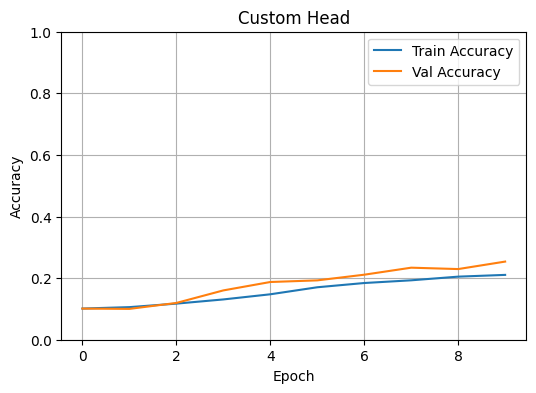

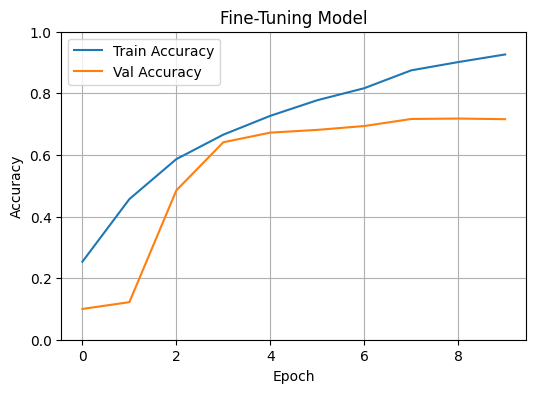

In [ ]:
def plot_history(history, title):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(history_head, "Custom Head")
plot_history(history_finetune, "Fine-Tuning Model")

### Predictions

In [ ]:
y_pred_probs = model.predict(test_images)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(test_labels, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 136ms/step


### Classification report

In [ ]:
# List of labels
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Changing numerical labels to labels from list
y_true_labels = [classes[i] for i in y_true]
y_pred_labels = [classes[i] for i in y_pred]

In [ ]:
print(classification_report(y_true_labels, y_pred_labels, target_names=classes))

              precision    recall  f1-score   support

    airplane       0.76      0.70      0.73      1000
  automobile       0.82      0.82      0.82      1000
        bird       0.63      0.63      0.63      1000
         cat       0.55      0.56      0.55      1000
        deer       0.64      0.67      0.65      1000
         dog       0.70      0.56      0.62      1000
        frog       0.75      0.81      0.78      1000
       horse       0.74      0.79      0.76      1000
        ship       0.78      0.84      0.81      1000
       truck       0.79      0.79      0.79      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



### Confusion matrix

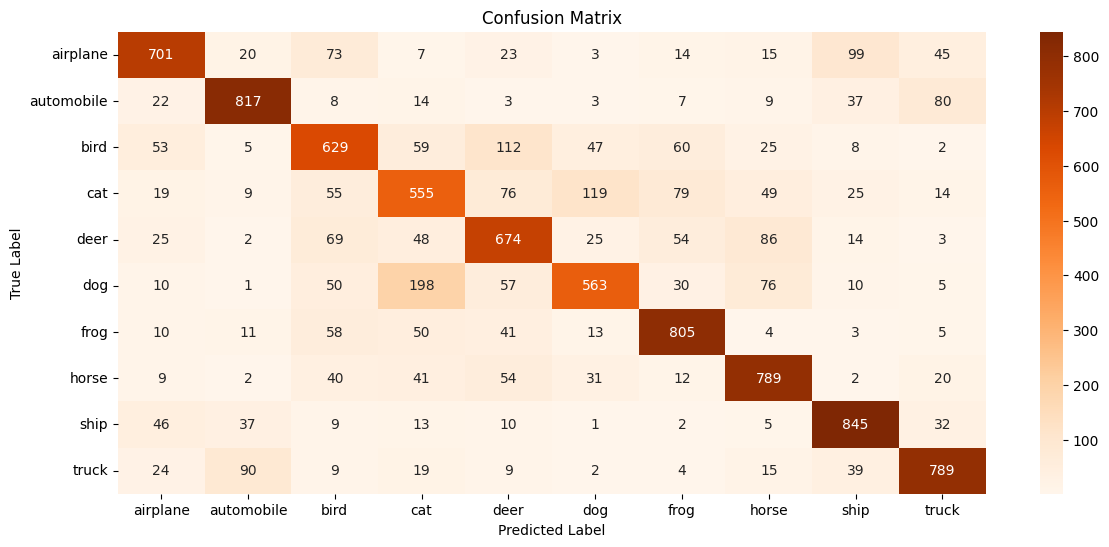

In [ ]:
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=classes)

plt.figure(figsize=(14, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Examples for false classification

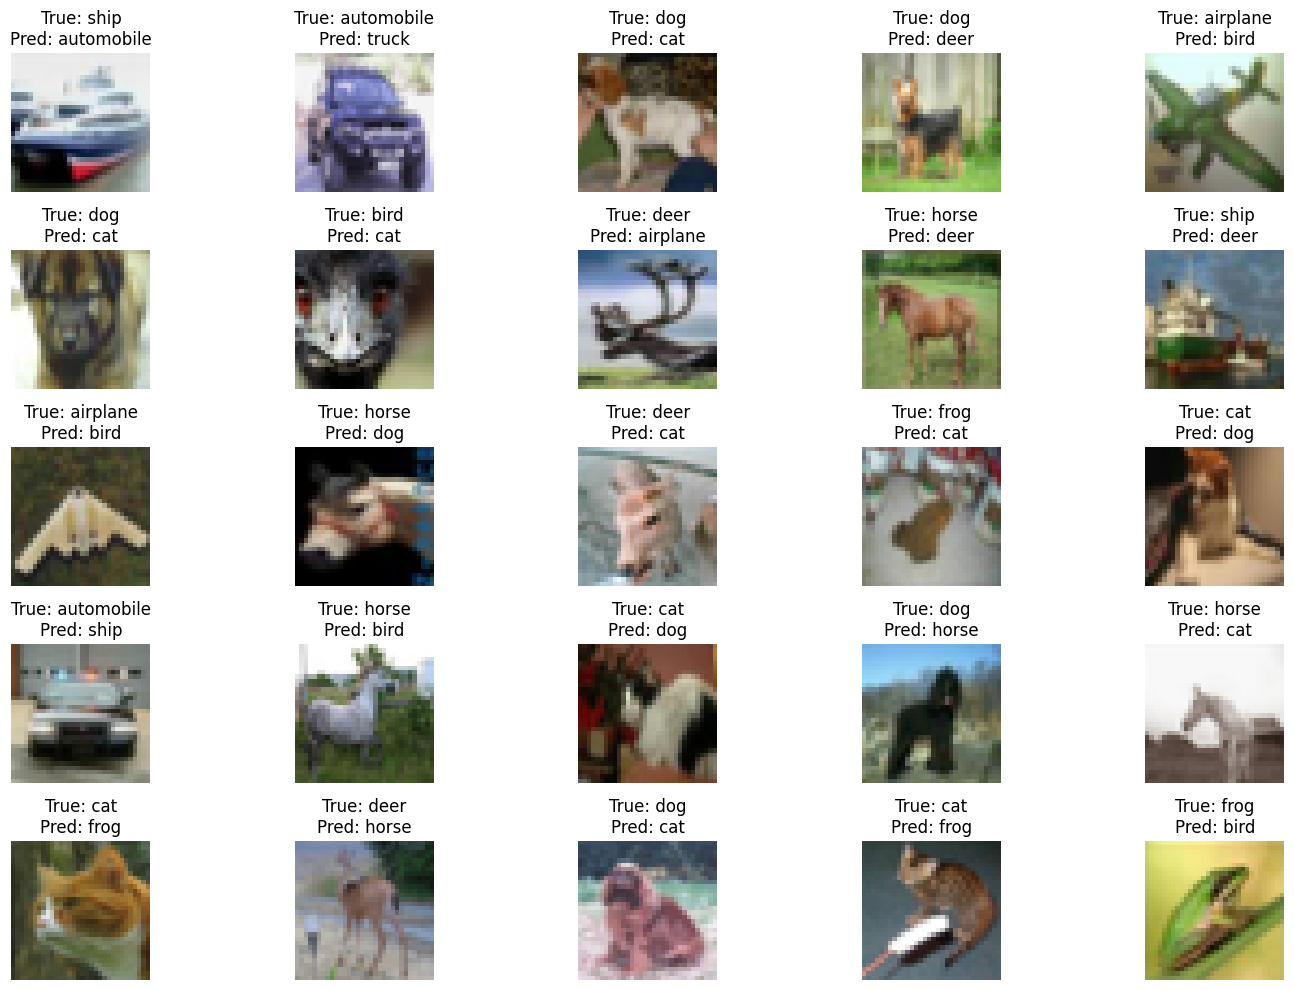

In [ ]:
# Plotting some false examples
misclassified_indices = np.where(y_pred != y_true)[0][:25]

plt.figure(figsize=(15, 10))
for i, idx in enumerate(misclassified_indices):
    plt.subplot(5, 5, i + 1)
    plt.imshow(test_images[idx])
    plt.title(f"True: {classes[y_true[idx]]}\nPred: {classes[y_pred[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Final conclusion and recommendations

In this project, I focused not just on achieving high accuracy, but on understanding and implementing the core steps involved in training a deep learning model for image classification. Using the CIFAR-10 dataset, I built a custom classification pipeline based on the ResNet50 architecture and applied the principles of transfer learning.

The key goal was to go through all major stages of a deep learning workflow: selecting and preprocessing data, designing a network architecture, applying data augmentation, choosing and tuning an optimizer, and finally evaluating the model both numerically and visually. I also explored how different configurations of hidden layers, activation functions, and dropout layers affect performance and generalization.

I began by freezing the convolutional base of ResNet50 and training a custom classification head. After that, I fine-tuned the model by gradually unfreezing layers and reducing the learning rate. Throughout training, I used callbacks like ReduceLROnPlateau and EarlyStopping to stabilize learning and avoid overfitting.

Due to hardware constraints, I limited the training to 10,000 samples, which made experimentation faster but likely impacted overall model performance. Nevertheless, I was able to reach a validation accuracy of approximately 73%, which is a good result considering the dataset size and reduced training time.

For future improvements, I would consider:
- Training on the full dataset to exploit more visual information.
- Exploring other pre-trained models such as MobileNet or EfficientNet.
- Applying more aggressive data augmentation (e.g., zoom, brightness changes).
- Fine-tuning more layers of the base model with a smaller learning rate.

This project helped me understand the complete deep learning workflow and reinforced the importance of thoughtful architecture design and training strategy. The ability to visualize predictions, track performance, and make decisions based on metrics was a valuable part of the process.